In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryCrossentropy 
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import Input, Add , Conv2D, MaxPooling2D, Flatten, Dense, Flatten, Dense, UpSampling2D,  Conv2DTranspose, Reshape, BatchNormalization,InputLayer, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.python.client import device_lib
import keras.backend as K
import os
import random
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import itertools
import re

In [2]:
# Check for GPU device(s)

gpu = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

logical_gpu = tf.config.experimental.list_logical_devices('GPU')
print(len(gpu),'Physical GPU,',len(logical_gpu),'Logical GPU')
\
###################################################################################
######## USER SHOULD HAVE ALREADY CREATED VALID AND TRAINING LABELS/SAMPLES #######
###################################################################################

# Network parameters 

patch_dim = 128        # patch size  

# Extract number of training and valid files, as well as their dimensions
# Use directory created in "py_generate_dispersions"

my_dir = 'C:...'
# USER SHOULD SPECIFY PATH WHERE THEY SAVED THE TRAINING IMAGES GENERATED IN MATLAB

dir = os.chdir(my_dir)
list = os.listdir(my_dir+'/train_labels') 
num_train = len(list)
#Start and end indices, in case we don't want to read in entire data set
start_ind_train = 0
end_ind_train = 100


num_train = end_ind_train - start_ind_train

train_labels = np.zeros((num_train,patch_dim,patch_dim,1))
train_samples = np.zeros((num_train,patch_dim,patch_dim,1))


for i in range(start_ind_train,end_ind_train):
    x = np.loadtxt('train_labels/x'+str(i)+'.txt')
    x = np.rot90(x)
    train_labels[i-start_ind_train,:,:,0] = x
    y = np.loadtxt('train_samples/y'+str(i)+'.txt')  
    y = np.rot90(y)
    train_samples[i-start_ind_train,:,:,0] = y

train_samples.shape

    
my_dir = 'C:...'
# USER SHOULD SPECIFY PATH WHERE THEY SAVED THE VALIDATION IMAGES GENERATED IN MATLAB

dir = os.chdir(my_dir)
list = os.listdir(my_dir+'/valid_labels') 
num_valid = len(list)
#Start and end indices, in case we don't want to read in entire data set
start_ind_valid = 0
end_ind_valid = 100
num_valid = end_ind_valid - start_ind_valid

valid_labels = np.zeros((num_valid,patch_dim,patch_dim,1))
valid_samples = np.zeros((num_valid,patch_dim,patch_dim,1)) 

for i in range(start_ind_valid,end_ind_valid):
    x = np.loadtxt('valid_labels/x'+str(i)+'.txt')
    x = np.rot90(x)
    valid_labels[i-start_ind_valid,:,:,0] = x
    y = np.loadtxt('valid_samples/y'+str(i)+'.txt')
    y = np.rot90(y)
    valid_samples[i-start_ind_valid,:,:,0] = y
    
valid_samples.shape   

Num GPUs Available:  1
1 Physical GPU, 1 Logical GPU


(2000, 128, 128, 1)

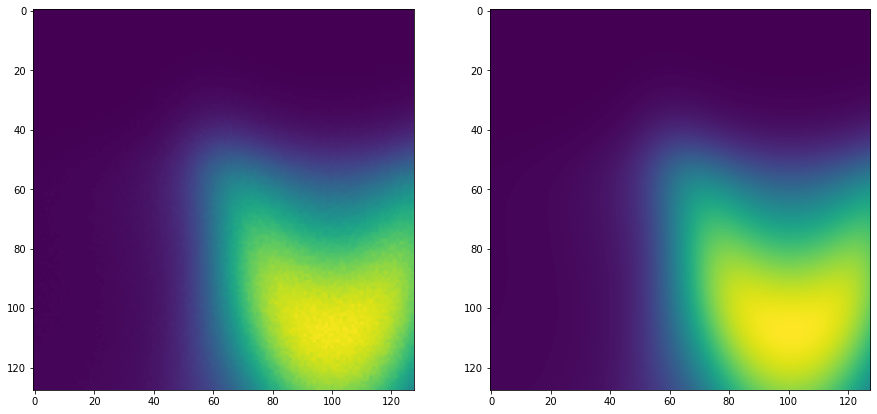

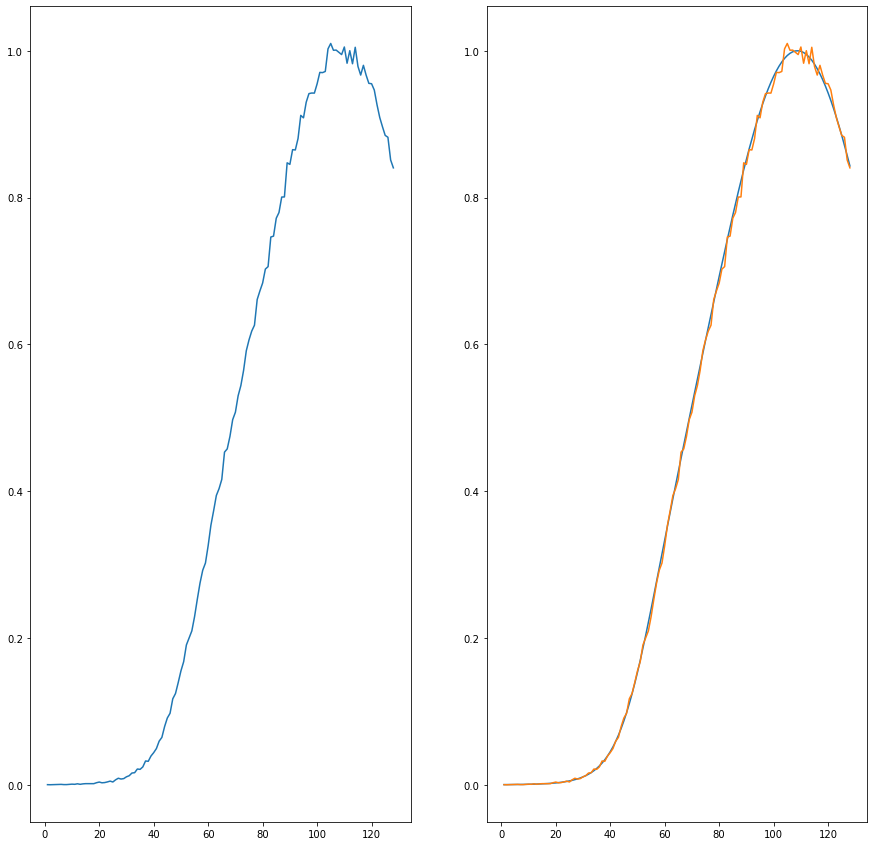

In [33]:
# QUICK VIEW OF LABELS AND SAMPLES

# figure size in inches optional
rcParams['figure.figsize'] = 15 ,15
index = 5   # dispersion index
fig, ax = plt.subplots(1,2)
sample = valid_samples[index,:,:,0]
label = valid_labels[index,:,:,0]
dims_label = label.shape
dims_sample = sample.shape
ax[0].imshow(sample);
ax[1].imshow(label);

fig, ax = plt.subplots(1,2)
label_evec = np.linspace(1,dims_label[0],dims_label[0])
sample_evec = np.linspace(1,dims_sample[0],dims_sample[0])

ind = 100 # edc index

sample_edc = sample[:,ind]
label_edc = label[:,ind]

ax[0].plot(sample_evec,sample_edc)
ax[1].plot(label_evec,label_edc)
ax[1].plot(sample_evec,sample_edc)

In [54]:
#### Best working model so far

patch_dim = 128
model = Sequential([
    keras.layers.Input(shape = (patch_dim,patch_dim,1)), 
    BatchNormalization(),
    Conv2D(filters = 128, strides = 1, activation = 'relu', kernel_size = (3,3), padding = 'same'), 
    BatchNormalization(),
    Conv2D(filters = 64, strides = 1, activation = 'relu', kernel_size = (6,6), padding = 'same'), 
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(filters = 32, strides = 1, activation = 'relu', kernel_size = (15,15), padding = 'same'), 
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    UpSampling2D(),
    Conv2DTranspose(filters = 32, strides = 1, activation = 'relu', kernel_size = (15,15), padding = 'same'),
    BatchNormalization(),
    UpSampling2D(),
    Conv2DTranspose(filters = 64, strides = 1, activation = 'relu', kernel_size = (6,6), padding = 'same'), 
    BatchNormalization(),
    Conv2DTranspose(filters = 128, strides = 1, activation = 'relu', kernel_size = (3,3), padding = 'same'),
    BatchNormalization(),
    Conv2DTranspose(filters = 1, strides = 1, kernel_size = (1,1), activation = 'sigmoid', padding = 'same')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_21 (Batc (None, 128, 128, 1)       4         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     1280      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      294976    
_________________________________________________________________
batch_normalization_23 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)       

In [331]:
# Now, we try the network of Kim et al. (https://arxiv.org/pdf/1511.04587.pdf)
initializer = tf.keras.initializers.HeNormal()

input_samples = train_samples
patch_dim = input_samples[0,:,:,0].shape[0]

x1 = Input(shape = (patch_dim,patch_dim,1))

    
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x1)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = initializer, kernel_regularizer = tf.keras.regularizers.l2(0.0001))(x) 
x = BatchNormalization()(x)
x = Conv2D(filters = 1, kernel_size = 3, padding = 'same')(x)
x = BatchNormalization()(x)


x = Add()([x1,x])
x = Activation('linear')(x)


model = Model(inputs=x1, outputs=x)

def customLoss(yTrue,yPred):
    weights = 1/(yTrue+0.001)
    return K.mean(K.square(yTrue-yPred)*weights)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 128, 128, 64) 640         input_44[0][0]                   
__________________________________________________________________________________________________
batch_normalization_217 (BatchN (None, 128, 128, 64) 256         conv2d_120[0][0]                 
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 128, 128, 64) 36928       batch_normalization_217[0][0]    
____________________________________________________________________________________________

Epoch 1/80
Learning rate:  0.001
219/219 - 20s - loss: 0.0423 - val_loss: 0.0235
Epoch 2/80
Learning rate:  0.001
219/219 - 18s - loss: 0.0082 - val_loss: 0.0120
Epoch 3/80
Learning rate:  0.001
219/219 - 18s - loss: 0.0053 - val_loss: 0.0051
Epoch 4/80
Learning rate:  0.001
219/219 - 18s - loss: 0.0042 - val_loss: 0.0044
Epoch 5/80
Learning rate:  0.001
219/219 - 18s - loss: 0.0036 - val_loss: 0.0032
Epoch 6/80
Learning rate:  0.001
219/219 - 19s - loss: 0.0032 - val_loss: 0.0060
Epoch 7/80
Learning rate:  0.001
219/219 - 19s - loss: 0.0030 - val_loss: 0.0037
Epoch 8/80
Learning rate:  0.001
219/219 - 19s - loss: 0.0028 - val_loss: 0.0026
Epoch 9/80
Learning rate:  0.001
219/219 - 19s - loss: 0.0027 - val_loss: 0.0029
Epoch 10/80
Learning rate:  0.001
219/219 - 19s - loss: 0.0026 - val_loss: 0.0028
Epoch 11/80
Learning rate:  0.001
219/219 - 19s - loss: 0.0024 - val_loss: 0.0031
Epoch 12/80
Learning rate:  0.001
219/219 - 19s - loss: 0.0023 - val_loss: 0.0028
Epoch 13/80
Learning rate

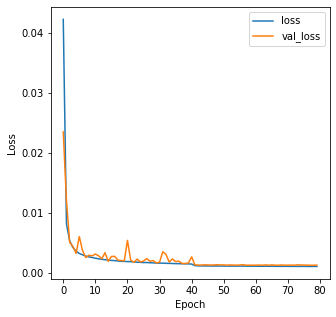

In [55]:

def lr_schedule(epoch):
    lr = 1e-3
    if  epoch > 200:
        lr = lr*1e-5
    elif epoch > 160:
        lr = lr*1e-4
    elif epoch > 120:
        lr = lr*1e-3
    elif epoch > 80:
        lr = lr*1e-2
    elif epoch > 40:
        lr = lr*1e-1
    print('Learning rate: ', lr)
    return lr
        
lr_scheduler = LearningRateScheduler(lr_schedule)  

callback = lr_scheduler
model.compile(loss = 'mse')

# Train the network
history = model.fit(train_samples, train_labels, epochs = 80, batch_size = 32, validation_data = (valid_samples, valid_labels), verbose = 2,callbacks = [callback])


# Plot loss and accuracy
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')

plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')

os.chdir(r'C:...')
# USER SHOULD SELECT DIRECTORY TO SAVE LEARNING CURVES

np.savetxt('train_loss.txt', history.history['loss'], delimiter=' ',fmt='%1.5f')
np.savetxt('valid_loss.txt', history.history['val_loss'], delimiter=' ',fmt='%1.5f')